In [63]:
''' Import libraries '''
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt
from IPython.display import display
from scipy import optimize as opt
import math
import random
import shutil

## Config

In [64]:
# path = '/home/phw93/dev/calib/data/*.jpg'
path = '/home/phw/dev/calib/data/*.jpg'

checkboard = [8,6] # height, width
boardSize = 2
visualize_en = 1 # 0 off, 1 on
real_points = []
real_points_x_y = []
imgIdx = []

## Functions

In [65]:

def load_images(path, imgIdx):

    image_files = glob.glob(path)
    image_files = sorted(image_files)
    images = []
    gray_images = []
    i = 0
    for image_file in image_files:
        image = cv2.imread(image_file)
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY).astype(np.float32) / 255.0
        images.append(image)
        gray_images.append(gray_image)
        imgIdx.append(i)
        i += 1

    # check 
    images_len = len(gray_images)
    w, h = gray_images[2].shape
    print("Width, Height: ",w, h)
    print("Image len: ", images_len)
    print("Checker board size: ",checkboard[0], checkboard[1])
    print('------')
    
    return images, gray_images, imgIdx
    

In [66]:
def extract_corner_and_NMS(images, gray_images, imgIdx):
    # extract corner & NMS
    arrCorners = []
    selectedImg = []
    selectedGrayImg = []
    newIdx = []
    window_size = 3
    winSize = (window_size*2+1, window_size*2+1)
    zeroZone = (-1, -1)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.001)
    for i in range(len(gray_images)):
        mask = np.empty((0, 0), dtype=np.float32)
        temp = cv2.convertScaleAbs(gray_images[i])  
        ret, corners = cv2.findChessboardCorners(temp, checkboard, None)
        if ret == True:
            refined_corners = cv2.cornerSubPix(gray_images[i], corners, winSize, zeroZone, criteria)
            refined_corners = refined_corners.reshape(-1,2)
            arrCorners.append(refined_corners)
            selectedImg.append(images[i])
            selectedGrayImg.append(gray_images[i])
            newIdx.append(imgIdx[i])
            
    print(corners.shape)
    return selectedImg, selectedGrayImg , arrCorners, newIdx

In [67]:
def filter_corners(images, gray_images, imgIdx, arrCorners, threshold, checkboard):
    # draw corners
    filtImg = []
    filtGrayImg = []
    filtCorners = []
    filtIdx = []
    for image, gray_image, corners, idx in zip(images, gray_images, arrCorners, imgIdx):
        if(len(corners)>=(checkboard[0] * checkboard[1] + 3 * (checkboard[0] + checkboard[1]))):
            continue    
        temp = image.copy()
        mean = np.mean(corners, axis=0)
        variance = np.var(corners, axis=0)
        # 분산을 기준으로 일정 이내에 있는 포인트들 필터링
#         threshold = 1.3  # 일정 분산 임계값 (조정 가능)
        filtered_points = []
        for corner in corners:
            if np.all(np.abs(corner - mean) <= threshold * np.sqrt(variance)):
                filtered_points.append(corner)
                x, y = corner[0].astype(int), corner[1].astype(int)
                # if(visualize_en):
                #     cv2.drawMarker(temp, (x, y), color=(0, 0, 255), markerType=cv2.MARKER_STAR, markerSize=10, thickness=3)
        if(len(filtered_points) == checkboard[0] * checkboard[1]):
            filtCorners.append(filtered_points)
            filtImg.append(temp)
            filtGrayImg.append(gray_image)
            filtIdx.append(idx)
    
    return filtImg, filtGrayImg, filtCorners, filtIdx
    

In [68]:
def draw_corners(n, filtImg, filtCorners):
    # 이미지 표시
    plt.imshow(filtImg[n], cmap='gray')
    print("selected images count: ", len(filtCorners))
    print("found corner count: ", len(filtCorners[n]))

def put_txtcorners(n, filtImg, filtCorners, flags):
    l = 0
    tempImgs = []
    for img in filtImg:
        temp = np.copy(img)
        k = 0
        for i in range(checkboard[0]):
            for j in range(checkboard[1]):
                if(flags[l] == 1):
                    x, y = filtCorners[l][k][0].astype(int), filtCorners[l][k][1].astype(int)
                    cv2.drawMarker(temp, (x, y), color=(255, 0, 0), markerType=cv2.MARKER_STAR, markerSize=8, thickness=3)
                    x, y = (filtCorners[l][k][0]).astype(int)*2-280, (filtCorners[l][k][1]).astype(int)*2-1000
                    cv2.putText(temp, f"({i}, {j})", (x, y), cv2.FONT_HERSHEY_PLAIN, 3, (255, 0, 0), 3)
                elif(flags[l] == 2):
                    x, y = filtCorners[l][k][0].astype(int), filtCorners[l][k][1].astype(int)
                    cv2.drawMarker(temp, (x, y), color=(255, 0, 0), markerType=cv2.MARKER_STAR, markerSize=8, thickness=3)
                    x, y = (filtCorners[l][k][0]*2.1).astype(int)-700, (filtCorners[l][k][1]*1.2).astype(int)+400
                    cv2.putText(temp, f"({i}, {j})", (x, y), cv2.FONT_HERSHEY_PLAIN, 3, (255, 0, 0), 3)
                elif(flags[l] == 3):
                    x, y = filtCorners[l][k][0].astype(int), filtCorners[l][k][1].astype(int)
                    cv2.drawMarker(temp, (x, y), color=(255, 0, 0), markerType=cv2.MARKER_STAR, markerSize=8, thickness=3)
                    x, y = (filtCorners[l][k][0]*2.1).astype(int)-800, (filtCorners[l][k][1]*1.0).astype(int)-400
                    cv2.putText(temp, f"({i}, {j})", (x, y), cv2.FONT_HERSHEY_PLAIN, 3, (255, 0, 0), 3)
                k += 1
        l += 1
        tempImgs.append(temp)
        
    plt.imshow(tempImgs[n], cmap='gray')
    return tempImgs

### Zhang's method Functions
Ref: https://github.com/SPengLiang/Camera-Calibration-of-Zhang-s-method/tree/master

In [69]:
# Homography Function
def normalizing_input_data(coor_data):

    coor_data = np.array(coor_data)
    x_avg = np.mean(coor_data[:, 0])
    y_avg = np.mean(coor_data[:, 1])
    sx = np.sqrt(2) / np.std(coor_data[:, 0])
    sy = np.sqrt(2) / np.std(coor_data[:, 1])

    norm_matrix = np.matrix([[sx, 0, -sx * x_avg],
                             [0, sy, -sy * y_avg],
                             [0, 0, 1]])
    return norm_matrix

def get_homography(pic_coor, real_coor):
    # normalize matrix
    pic_norm_mat = normalizing_input_data(pic_coor)
    real_norm_mat = normalizing_input_data(real_coor)

    M = []
    for i in range(len(pic_coor)):
        # convert homogeneous coordinate
        single_pic_coor = np.array([pic_coor[i][0], pic_coor[i][1], 1])
        single_real_coor = np.array([real_coor[i][0], real_coor[i][1], 1])

        # normalize
        pic_norm = np.dot(pic_norm_mat, single_pic_coor)
        real_norm = np.dot(real_norm_mat, single_real_coor)

        M.append(np.array([-real_norm.item(0), -real_norm.item(1), -1,
                      0, 0, 0,
                      pic_norm.item(0) * real_norm.item(0), pic_norm.item(0) * real_norm.item(1), pic_norm.item(0)]))

        M.append(np.array([0, 0, 0,
                      -real_norm.item(0), -real_norm.item(1), -1,
                      pic_norm.item(1) * real_norm.item(0), pic_norm.item(1) * real_norm.item(1), pic_norm.item(1)]))

    # SVD M*h=0 we need h
    U, S, VT = np.linalg.svd((np.array(M, dtype='float')).reshape((-1, 9)))
    H = VT[-1].reshape((3, 3))
    H = np.dot(np.dot(np.linalg.inv(pic_norm_mat), H), real_norm_mat)
    H /= H[-1, -1]

    return H

def useRANSAChomography(pic_coor, real_coor, num_iterations=100, threshold=5):
    best_inliers = []
    best_H = None

    for _ in range(num_iterations):
        # Randomly select four point correspondences
        random_indices = random.sample(range(len(pic_coor)), 4)
        pic_coor_subset = [pic_coor[i] for i in random_indices]
        real_coor_subset = [real_coor[i] for i in random_indices]

        # Compute homography using the subset of point correspondences
        H = compute_homography(pic_coor_subset, real_coor_subset)

        # Count inliers
        inliers = []
        for i in range(len(pic_coor)):
            error = compute_reprojection_error(H, pic_coor[i], real_coor[i])
            if error < threshold:
                inliers.append(i)

        # Check if current model is the best so far
        if len(inliers) > len(best_inliers):
            best_inliers = inliers
            best_H = H

    # Refine homography using all inliers
    inlier_pic_coor = [pic_coor[i] for i in best_inliers]
    inlier_real_coor = [real_coor[i] for i in best_inliers]
    best_H = compute_homography(inlier_pic_coor, inlier_real_coor)

    return best_H

def compute_homography(pic_coor_subset, real_coo_subset):
    
    M = []
    
    pic_norm_mat = normalizing_input_data(pic_coor_subset)
    real_norm_mat = normalizing_input_data(real_coo_subset)
    
    for i in range(len(pic_coor_subset)):
    # convert homogeneous coordinate
        single_pic_coor = np.array([pic_coor_subset[i][0], pic_coor_subset[i][1], 1])
        single_real_coor = np.array([real_coo_subset[i][0], real_coo_subset[i][1], 1])

    # normalize
    pic_norm = np.dot(pic_norm_mat, single_pic_coor)
    real_norm = np.dot(real_norm_mat, single_real_coor)

    M.append(np.array([-real_norm.item(0), -real_norm.item(1), -1,
                      0, 0, 0,
                    pic_norm.item(0) * real_norm.item(0), pic_norm.item(0) * real_norm.item(1), pic_norm.item(0)]))

    M.append(np.array([0, 0, 0,
                    -real_norm.item(0), -real_norm.item(1), -1,
                    pic_norm.item(1) * real_norm.item(0), pic_norm.item(1) * real_norm.item(1), pic_norm.item(1)]))

    # SVD M*h=0 we need h
    U, S, VT = np.linalg.svd((np.array(M, dtype='float')).reshape((-1, 9)))
    H = VT[-1].reshape((3, 3))
    H = np.dot(np.dot(np.linalg.inv(pic_norm_mat), H), real_norm_mat)
    H /= H[-1, -1]

    return H


def compute_reprojection_error(H, pic_coor, real_coor):
    Y = np.array([])
    for i in range(len(real_coor)):
        single_real_coor = np.array([real_coor[i, 0], real_coor[i, 1], 1])
        U = np.dot(H.reshape(3, 3), single_real_coor)
        U /= U[-1]
        Y = np.append(Y, U[:2])

    Y_NEW = (pic_coor.reshape(-1) - Y)

    return Y_NEW

In [70]:
# Get Intrinsic
# Returns the vector v corresponding to the location pq.
def create_v(p, q, H):
    H = H.reshape(3, 3)
    return np.array([
        H[0, p] * H[0, q],
        H[0, p] * H[1, q] + H[1, p] * H[0, q],
        H[1, p] * H[1, q],
        H[2, p] * H[0, q] + H[0, p] * H[2, q],
        H[2, p] * H[1, q] + H[1, p] * H[2, q],
        H[2, p] * H[2, q]
    ])

def get_intrinsics_param(H):
    # V matrix
    V = np.array([])
    for i in range(len(H)):
        V = np.append(V, np.array([create_v(0, 1, H[i]), create_v(0, 0 , H[i])- create_v(1, 1 , H[i])]))
    # print('V: ', V)
    # V*b=0 Solve b
    U, S, VT = np.linalg.svd((np.array(V, dtype='float')).reshape((-1, 6)))
    b = VT[-1]
    # print('b: ', b)
    # Find camera intrinsic
    w = b[0] * b[2] * b[5] - b[1] * b[1] * b[5] - b[0] * b[4] * b[4] + 2 * b[1] * b[3] * b[4] - b[2] * b[3] * b[3]
    d = b[0] * b[2] - b[1] * b[1]

    alpha = np.sqrt(w / (d * b[0]))
    # print('beta => w: ', w, 'd: ', d, 'b[0]: ', b[0])
    beta = np.sqrt(w / d**2 * b[0])
    # print('gamma => w: ', w, 'd: ', d, 'b[0]: ', b[0], 'b[1]: ', b[1])
    gamma = np.sqrt(w / (d**2 * b[0])) * b[1]
    uc = (b[1] * b[4] - b[2] * b[3]) / d
    vc = (b[1] * b[3] - b[0] * b[4]) / d

    return np.array([
        [alpha, gamma, uc],
        [0,     beta,  vc],
        [0,     0,      1]
    ])
    
# Get Extrinsic
def get_extrinsics_param(H, intrinsics_param):
    extrinsics_param = []

    inv_intrinsics_param = np.linalg.inv(intrinsics_param)
    # print(inv_intrinsics_param)
    for i in range(len(H)):
        h0 = (H[i].reshape(3, 3))[:, 0] # 0 col
        h1 = (H[i].reshape(3, 3))[:, 1] # 1 col
        h2 = (H[i].reshape(3, 3))[:, 2] # 2 col
        # print(H[i])
        scale_factor = 1 / np.linalg.norm(np.dot(inv_intrinsics_param, h0))
        # print('scale factor: ', scale_factor)
        r0 = scale_factor * np.dot(inv_intrinsics_param, h0)
        r1 = scale_factor * np.dot(inv_intrinsics_param, h1)
        t = scale_factor * np.dot(inv_intrinsics_param, h2)
        r0sq = np.squeeze(r0)
        r1sq = np.squeeze(r1)
        r2 = np.cross(r0sq, r1sq)
        r2 = r2.reshape((3, 1))
        # print('r0: ', r0)
        # print('r1: ', r1)
        # print('r2: ', r2)
        # print('t: ', t)
        # print(r0.shape, r2.shape)
        R = np.array([r0, r1, r2, t]).transpose()
        extrinsics_param.append(R)

    return extrinsics_param

In [71]:
def to_rodrigues_vector(R):
    p = 0.5 * np.array([[R[2, 1] - R[1, 2]],
                        [R[0, 2] - R[2, 0]],
                        [R[1, 0] - R[0, 1]]])
    c = 0.5 * (np.trace(R) - 1)

    if np.linalg.norm(p) == 0:
        if c == 1:
            zrou = np.array([0, 0, 0])
        elif c == -1:
            R_plus = R + np.eye(3, dtype='float')

            norm_array = np.array([np.linalg.norm(R_plus[:, 0]),
                                   np.linalg.norm(R_plus[:, 1]),
                                   np.linalg.norm(R_plus[:, 2])])
            v = R_plus[:, np.where(norm_array == max(norm_array))]
            u = v / np.linalg.norm(v)
            if u[0] < 0 or (u[0] == 0 and u[1] < 0) or (u[0] == u[1] and u[0] == 0 and u[2] < 0):
                u = -u
            zrou = math.pi * u
        else:
            zrou = []
    else:
        u = p / np.linalg.norm(p)
        theata = math.atan2(np.linalg.norm(p), c)
        zrou = theata * u

    return zrou

def to_rotation_matrix(zrou):
    theta = np.linalg.norm(zrou)
    zrou_prime = zrou / theta

    W = np.array([[0, -zrou_prime[2], zrou_prime[1]],
                  [zrou_prime[2], 0, -zrou_prime[0]],
                  [-zrou_prime[1], zrou_prime[0], 0]])
    R = np.eye(3, dtype='float') + W * math.sin(theta) + np.dot(W, W) * (1 - math.cos(theta))

    return R

In [72]:
# Calibration
def calibrate(pic_coord, real_points, real_points_x_y):
    Homographys = []
    # Find homography
    for i in range(len(pic_coord)):
        # initial_H = useRANSAChomography(pic_coord[i], real_points_x_y[i])
        initial_H = get_homography(pic_coord[i], real_points_x_y[i])
        # print(initial_H)
        Homographys.append(initial_H)
    
    # Find Intrinsic
    intrinsic = get_intrinsics_param(Homographys)
    print('K: ', intrinsic)

    # Find extrinsic
    extrinsics = get_extrinsics_param(Homographys, intrinsic)

    return intrinsic, extrinsics
        

### Matching Functions

In [73]:
def distance_from_origin(point):
    return math.sqrt(point[0]**2 + point[1]**2)

def distance(point1, point2):
    return math.sqrt((point2[0] - point1[0])**2 + (point2[1] - point1[1])**2)

def find_closest_points(points, reference_point, k=2):
    sorted_points = sorted(points, key=lambda point: distance(point, reference_point))
    return sorted_points[1:k+1]  # 첫 번째 포인트는 자기 자신이므로 제외하고 반환

def compute_direction_vec(reference_point, closest_point):
    direction_vector = (closest_point[0] - reference_point[0], closest_point[1] - reference_point[1])
    return direction_vector

def direction_vec_esti(closest_points, reference_point):
    direction_vector = (closest_points[0] - reference_point[0], closest_points[1] - reference_point[1])
    return direction_vector

def normalize_vector(vector):
    magnitude = math.sqrt(vector[0]**2 + vector[1]**2)
    normalized_vector = (vector[0] / magnitude, vector[1] / magnitude)
    return normalized_vector

def dot_product(vector1, vector2):
    return vector1[0] * vector2[0] + vector1[1] * vector2[1]

def matching(filtImgs, filtGrayImgs, filtCorners, imgIdx, disthresh = 0.8):
    sortedMatching = []
    tempImgs = []
    tempGrayImgs = []
    flags = []
    newIdx = []
    excNum = 0
    for i in range(len(filtCorners)):
        sorted_corners = sorted(filtCorners[i], key=lambda k: (k[0], k[1]))
        # sorted_by_x_and_distance = sorted(sorted_corners, key=lambda k: (distance_from_origin(k)))
        # for j in range(len(sorted_by_x_and_distance)):
        #     print(sorted_by_x_and_distance[j])
        # refer = sorted_by_x_and_distance[:3]
        reference_point = min(filtCorners[i], key=lambda point: point[0])
        closest_points = find_closest_points(sorted_corners, reference_point, k=2)
        closest_points = sorted(closest_points, key=lambda k: k[1])
        esti_vec0 = direction_vec_esti(closest_points[0], reference_point)
        esti_vec1 = direction_vec_esti(closest_points[1], reference_point)
        norm_close0 = normalize_vector(esti_vec0)
        norm_close1 = normalize_vector(esti_vec1)
        # print(norm_close0, norm_close1)
        # print('dot_product closest: ', abs(dot_product(norm_close0, norm_close1)), i)
        if(abs(dot_product(norm_close0, norm_close1)) > 0.7):
            continue            
        norm_est_vec = normalize_vector(esti_vec0)
        product_vec = dot_product(norm_est_vec, (1,0))
        # print('ref: ',reference_point[0], reference_point[1], 'close: ', closest_points[0][0], closest_points[0][1],', ', closest_points[1][0], closest_points[1][1])
        # print('esti: ', esti_vec, 'norm: ', norm_est_vec, 'product: ', product_vec, i)
        
        temp = np.copy(filtImgs[i])
        tempGray = np.copy(filtGrayImgs[i])
        tempCorners = []
        if(visualize_en):
            cv2.drawMarker(temp, (reference_point[0].astype(int), reference_point[1].astype(int)), color=(0, 255, 0), markerType=cv2.MARKER_STAR, markerSize=10, thickness=5)
            cv2.drawMarker(temp, (closest_points[0][0].astype(int), closest_points[0][1].astype(int)), color=(255, 0, 0), markerType=cv2.MARKER_STAR, markerSize=10, thickness=5)
            cv2.drawMarker(temp, (closest_points[1][0].astype(int), closest_points[1][1].astype(int)), color=(255, 0, 0), markerType=cv2.MARKER_STAR, markerSize=10, thickness=5)
            cv2.putText(temp, "ref", (int(reference_point[0])-10, int(reference_point[1]-10)), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 2)
            cv2.putText(temp, "clos0", (int(closest_points[0][0])-10, int(closest_points[0][1]-10)), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 0, 0), 2)
            cv2.putText(temp, "clos1", (int(closest_points[1][0])-10, int(closest_points[1][1]-10)), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 0, 0), 2)
        if(product_vec > 0.999):
            ''' case 1 '''
            for k in range(0, checkboard[0]):
                # case1_hdir_points = sorted(sorted_corners, key=lambda point: math.sqrt((point[0] - tempRefPoint[0])**2 + (point[1] - tempRefPoint[1])**2))
                tempRefPoint = np.array([reference_point[0] + esti_vec1[0] * k, reference_point[1] + esti_vec1[1] * k])
                case1_hdir_point = min(sorted_corners, key=lambda point: math.sqrt((point[0] - tempRefPoint[0])**2 + (point[1] - tempRefPoint[1])**2))
                case1_hdir_point_copy = np.array([case1_hdir_point[0], case1_hdir_point[1]])
                
                # ## exception
                # if(case1_hdir_point_copy[0] != tempRefPoint[0]):
                #     hcase1_except = direction_vec_esti(case1_hdir_point_copy, tempRefPoint)
                #     hnorm_case1_except = normalize_vector(hcase1_except)
                #     hnorm_esti_vec1 = normalize_vector(esti_vec1)
                #     print('height esti: ', hnorm_esti_vec1, 'normcur: ', hnorm_case1_except, 'cur: ', hcase1_except)
                #     print(dot_product(hnorm_case1_except, hnorm_esti_vec1))
                #     # if(abs(dot_product(hnorm_case1_except, hnorm_esti_vec1)) > 0.1):
                #     #     case1_hdir_point = case1_hdir_points[1]
                #     #     case1_hdir_point_copy = np.array([case1_hdir_point[0], case1_hdir_point[1]])
                # ###                    
                tempCorners.append(case1_hdir_point_copy)
                for j in range(1, checkboard[1]):
                    # case1_wdir_points = sorted(sorted_corners, key=lambda point: math.sqrt((point[0] - case1_temp_refpoint[0])**2 + (point[1] - case1_temp_refpoint[1])**2))
                    case1_temp_refpoint = np.array([case1_hdir_point_copy[0] + esti_vec0[0] * j, case1_hdir_point_copy[1] + esti_vec0[1] * j])
                    case1_wdir_point = min(sorted_corners, key=lambda point: math.sqrt((point[0] - case1_temp_refpoint[0])**2 + (point[1] - case1_temp_refpoint[1])**2))
                    case1_wdir_point_copy = np.array([case1_wdir_point[0], case1_wdir_point[1]]) 
                    
                    # ### exception
                    # if(case1_wdir_point_copy[0] != case1_temp_refpoint[0]):
                    #     wcase1_except = direction_vec_esti(case1_wdir_point_copy, case1_temp_refpoint)
                    #     wnorm_case1_except = normalize_vector(wcase1_except)
                    #     wnorm_esti_vec0 = normalize_vector(esti_vec0)
                    #     print('width esti: ', wnorm_esti_vec0, 'normcur: ', wnorm_case1_except, 'cur: ', wcase1_except)
                    #     print(dot_product(wnorm_case1_except, wnorm_esti_vec0))
                    #     # if(dot_product(wnorm_case1_except, np.array([0,1])) > 0):
                    #     #     case1_wdir_point = case1_wdir_points[1]
                    #     #     case1_wdir_point_copy = np.array([case1_wdir_point[0], case1_wdir_point[1]])
                    # ###
                    tempCorners.append(case1_wdir_point_copy)
            flag = 1
            unique_set = set()
            has_duplicates = False
            for point in tempCorners:
                point_tuple = tuple(point)
                if point_tuple in unique_set:
                    has_duplicates = True
                    break
                unique_set.add(point_tuple)
            if(has_duplicates == False):
                flags.append(flag)
                sortedMatching.append(tempCorners)
                tempImgs.append(temp)
                tempGrayImgs.append(tempGray)
                newIdx.append(imgIdx[i])
                
                print('case 1', i)
                print('case 1 corners: ', len(sorted_corners) )
                            
            
        else:
            ''' case 2 & 3 '''
            rep=0
            tempRefPoint = np.array([reference_point[0], reference_point[1]])
            tempCorners.append(reference_point)
            esti_vec_mag = distance_from_origin(esti_vec0)
            while(True):
                tempRefPoint[0] += esti_vec0[0]
                tempRefPoint[1] += esti_vec0[1]
                next_point = min(sorted_corners, key=lambda point: math.sqrt((point[0] - tempRefPoint[0])**2 + (point[1] - tempRefPoint[1])**2))
                tempNextPoint = np.array([next_point[0], next_point[1]])

                distance = math.sqrt((tempNextPoint[0] - tempRefPoint[0])**2 + (tempNextPoint[1] - tempRefPoint[1])**2)
                # print('nextPoint: ', tempNextPoint, 'reference: ', tempRefPoint, 'distance: ', distance, rep)
                rep += 1
                if distance <= esti_vec_mag * disthresh:
                    tempCorners.append(next_point)
                else:
                    # checkboard = [8,6]
                    if(len(tempCorners) == checkboard[1]):
                        print('case 2', i)
                        flag = 2
                        
                        for k in range(1, checkboard[0]):
                            tempRefPoint = np.array([reference_point[0] + esti_vec1[0] * k, reference_point[1] + esti_vec1[1] * k])
                            case2_hdir_point = min(sorted_corners, key=lambda point: math.sqrt((point[0] - tempRefPoint[0])**2 + (point[1] - tempRefPoint[1])**2))
                            case2_hdir_point_copy = np.array([case2_hdir_point[0], case2_hdir_point[1]])
                            tempCorners.append(case2_hdir_point_copy)
                            for j in range(1, checkboard[1]):
                                case2_temp_refpoint = np.array([case2_hdir_point[0] + esti_vec0[0] * j, case2_hdir_point[1] + esti_vec0[1] * j])
                                case2_wdir_point = min(sorted_corners, key=lambda point: math.sqrt((point[0] - case2_temp_refpoint[0])**2 + (point[1] - case2_temp_refpoint[1])**2))
                                case2_wdir_point_copy = np.array([case2_wdir_point[0], case2_wdir_point[1]]) 
                                tempCorners.append(case2_wdir_point_copy)
                        
                        unique_set = set()
                        has_duplicates = False
                        for point in tempCorners:
                            point_tuple = tuple(point)
                            if point_tuple in unique_set:
                                has_duplicates = True
                                break
                            unique_set.add(point_tuple)
                        if(has_duplicates == False):
                            flags.append(flag)
                            sortedMatching.append(tempCorners)
                            tempImgs.append(temp)
                            tempGrayImgs.append(tempGray)
                            newIdx.append(imgIdx[i])
                            print('case 2 corners: ', len(tempCorners) )
                            break
                    elif(len(tempCorners) == checkboard[0]):
                        print('case 3', i)
                        flag = 3
                        
                        # print('orig ref: ', reference_point)
                        # print('change ref: ', tempCorners[-1])
                        reference_point = np.array([tempCorners[-1][0],tempCorners[-1][1]])
                        tempCorners = []
                        # reference_point = np.array([tempCorners,])
                        for k in range(0, checkboard[0]):
                            tempRefPoint = np.array([reference_point[0] - esti_vec0[0] * k, reference_point[1] - esti_vec0[1] * k])
                            case2_hdir_point = min(sorted_corners, key=lambda point: math.sqrt((point[0] - tempRefPoint[0])**2 + (point[1] - tempRefPoint[1])**2))
                            case2_hdir_point_copy = np.array([case2_hdir_point[0], case2_hdir_point[1]])
                            tempCorners.append(case2_hdir_point_copy)
                            for j in range(1, checkboard[1]):
                                case2_temp_refpoint = np.array([case2_hdir_point[0] + esti_vec1[0] * j, case2_hdir_point[1] + esti_vec1[1] * j])
                                case2_wdir_point = min(sorted_corners, key=lambda point: math.sqrt((point[0] - case2_temp_refpoint[0])**2 + (point[1] - case2_temp_refpoint[1])**2))
                                case2_wdir_point_copy = np.array([case2_wdir_point[0], case2_wdir_point[1]]) 
                                tempCorners.append(case2_wdir_point_copy)
                        
                        unique_set = set()
                        has_duplicates = False
                        for point in tempCorners:
                            point_tuple = tuple(point)
                            if point_tuple in unique_set:
                                has_duplicates = True
                                break
                            unique_set.add(point_tuple)
                        if(has_duplicates == False):
                            flags.append(flag)
                            sortedMatching.append(tempCorners)
                            tempImgs.append(temp)
                            tempGrayImgs.append(tempGray)
                            newIdx.append(imgIdx[i])
                            print('case 3 corners: ', len(tempCorners) )
                            break
                    else:
                        print('error matching')
                        excNum += 1
                        break
    
    print('except number: ', excNum, 'sorted num: ', len(sortedMatching))
    
    return tempImgs, tempGrayImgs, sortedMatching, newIdx, flags
        
    

# Run code

### IMAGE LOAD

In [74]:
images, gray_images, imgIdx = load_images(path, imgIdx)

Width, Height:  1920 1080
Image len:  114
Checker board size:  8 6
------


In [75]:
print(len(imgIdx))
print(imgIdx)

114
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113]


### Feature extract

In [76]:
images ,gray_images, arrCorners, imgIdx = extract_corner_and_NMS(images, gray_images, imgIdx)

(48, 1, 2)


### Filtered Checkboard Corner

In [77]:
print(len(imgIdx))
print(imgIdx)

113
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113]


In [78]:
filtImgs, filtGrayImgs, filtCorners, imgIdx= filter_corners(images, gray_images, imgIdx, arrCorners, 10, checkboard)


selected images count:  113
found corner count:  48
113


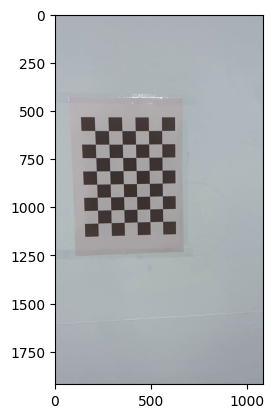

In [79]:
draw_corners(0, filtImgs, filtCorners)
print(len(imgIdx))

### Matching

In [80]:
filtImgs, filtGrayImgs, filtCorners, imgIdx, flags = matching(filtImgs, filtGrayImgs, filtCorners, imgIdx, 0.5)

case 1 0
case 1 corners:  48
case 1 1
case 1 corners:  48
case 1 2
case 1 corners:  48
case 1 3
case 1 corners:  48
case 2 6
error matching
case 3 7
error matching
case 3 8
error matching
case 3 9
error matching
case 3 10
error matching
case 3 11
error matching
case 3 12
case 3 corners:  48
case 3 13
case 3 corners:  48
case 3 15
case 3 corners:  48
case 3 16
case 3 corners:  48
case 3 17
case 3 corners:  48
case 3 18
error matching
case 3 19
error matching
case 3 20
error matching
case 3 21
case 3 corners:  48
case 1 22
case 1 corners:  48
case 1 23
case 1 corners:  48
case 1 24
case 1 corners:  48
case 3 25
case 3 corners:  48
error matching
case 2 27
error matching
case 2 28
error matching
error matching
error matching
error matching
error matching
error matching
error matching
error matching
case 2 36
error matching
case 2 37
error matching
error matching
case 3 39
case 3 corners:  48
case 1 40
case 1 corners:  48
case 1 41
case 1 corners:  48
case 2 47
error matching
case 2 48
err

67
[0, 1, 2, 3, 12, 13, 15, 16, 17, 21, 22, 23, 24, 25, 39, 40, 41, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 89, 91, 92, 93, 94, 95, 96, 97, 98, 99, 110, 111, 112, 113]


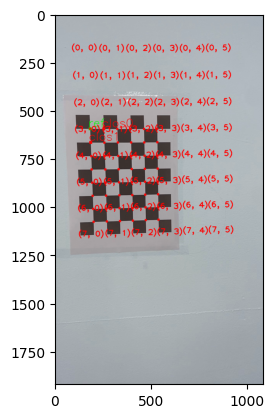

In [81]:
# Check Corner matching
sortedNum = 1 # 1 38 45
# draw_corners(sortedNum, filtImgs, filtCorners)
txtImgs = put_txtcorners(sortedNum, filtImgs, filtCorners, flags)
print(len(imgIdx))
print(imgIdx)

### Zhang's Method

In [82]:
real_coor = np.zeros((checkboard[0] * checkboard[1], 3), np.float32)
real_coor[:, :2] = np.mgrid[0:checkboard[1], 0:checkboard[0]].T.reshape(-1, 2)

for i in range(len(filtCorners)):
    real_points.append(real_coor)
    real_points_x_y.append(real_coor[:, :2])

filtCorners = np.array(filtCorners)
pic_points = []
for corner in filtCorners:
    corner = corner.reshape(-1,2)
    pic_points.append(corner)
    
# Get intrinsic, extrinsic
intrinsic, extrinsics = calibrate(pic_points, real_points, real_points_x_y)
for r in extrinsics:
    print(r)

K:  [[ 1.63520000e+03 -1.91111194e+00  5.49889435e+02]
 [ 0.00000000e+00  1.63145115e+03  9.74702498e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[[ 9.94579963e-01  1.33736600e-02 -1.03375692e-01 -4.89316998e+00]
  [-2.19322158e-02  9.93869711e-01 -1.05831059e-01 -5.28774904e+00]
  [ 1.01635012e-01  1.07774433e-01  9.88776214e-01  2.34571871e+01]]]
[[[ 9.92076451e-01  1.47873392e-02 -1.25072327e-01 -5.24957667e+00]
  [-2.62722489e-02  9.94257325e-01 -1.08441723e-01 -5.41999160e+00]
  [ 1.22857986e-01  1.11139082e-01  9.86767775e-01  2.33519494e+01]]]
[[[ 9.79320554e-01  1.50565097e-02 -2.01558374e-01 -5.32491403e+00]
  [-3.45637468e-02  9.91773466e-01 -1.06305712e-01 -5.40636813e+00]
  [ 1.99340414e-01  1.11615224e-01  9.71784549e-01  2.32089871e+01]]]
[[[ 9.55205523e-01  1.52768639e-02 -2.95757908e-01 -4.35665214e+00]
  [-4.32492092e-02  9.94429951e-01 -9.76238319e-02 -5.03032453e+00]
  [ 2.92765971e-01  1.06884200e-01  9.50545694e-01  2.36630231e+01]]]
[[[ 9.47647405e-01

### Select Image

In [83]:
for idx in imgIdx:
    image_count = str(idx).zfill(5)
    source_file = f'/home/phw/dev/calib/data/frame_{image_count}.jpg'
    target_path = '/home/phw/dev/calib/selectedImg/'
    shutil.copy(source_file, target_path)

### Visualize